<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression circle

How can we fit a circle on four or more points?

First let's try the least squares method (LSM) to find a solution.

Unfortunately the equations are not linear, but we can change it to a quadratic equation of a single variable:

${(x - x_0)}^{2} + {(y - y_0)}^{2} = r^2$

We have x and y positions of points on the circle, and we would like to find $x_0, y_0, r$.
Removing the bracket we get:

$x^2 - 2 x x_0 + {x_0}^2 + y^2 -2 y y_0 + {y_0}^2 = r^2$

Let's reorder the tags:

$y^2 + x^2  -2 x_0 x -2 y_0 y + x_0^2 + y_0^2 -r^2 = 0$

Lest substitute the unknowns:

$a_1 = -2 x_0$

$a_2 = -2 y_0$

$a_3 = x_0^2 + y_0^2 - r^2$

$x a_1 + y a_2 + a_3 =  -(x^2 + y^2)$

So we get a linear equation of three unknowns $a_1, a_2, a_3$ for each measured point, 
which is solved applying LSM using numpy.

Finally we can calculate the original unknowns:

$x_0 = -0.5 a_1$

$y_0 = -0.5 a_2$

$r = \sqrt {x_0^2 + y_0^2 - a_3}$

In [21]:
from math import sqrt, pi, sin, cos, sqrt   # used mathematical and trigonometrical functions
import numpy as np                          # matrix operations
import matplotlib.pyplot as plt             # chart plotting

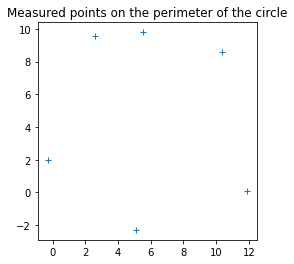

In [22]:
# sample data
x = np.array([ 11.88, 10.34, 2.58, -0.29, 5.1, 5.5])
y = np.array([  0.08,  8.59, 9.54,  1.95, -2.3, 9.8 ])
plt.plot(x, y, '+')
plt.axis('scaled')
_ = plt.title('Measured points on the perimeter of the circle')

Setting up and solving the equation system

$A x = b$

\begin{align}
        x = \begin{pmatrix}
            a_1 \\
            a_2 \\
            a_3 
            \end{pmatrix}.
\end{align}

\begin{align}
        A = \begin{pmatrix}
            x_1 & y_1 & 1 \\
            x_2 & y_2 & 1 \\
            x_3 & y_3 & 1 \\
            x_4 & y_4 & 1 \\
            x_5 & y_5 & 1 \\
            x_6 & y_6 & 1 
        \end{pmatrix}.
\end{align}

\begin{align}
    b = \begin{pmatrix}
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2
    \end{pmatrix}.
\end{align}

Note in the formula above the matrix indices start from 1 while in Python they start from 0.

In [23]:
# coefficients of unknowns
A = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
# pure terms
b = -(x * x + y * y)
# solution for a1, a2, a3
Q = np.linalg.inv(np.matmul(A.T, A))
par = np.matmul(Q, np.matmul(A.T, b))
# calculating the original unknowns
x0 = -0.5 * par[0]
y0 = -0.5 * par[1]
r = sqrt(x0**2 + y0**2 - par[2])
print("The equation of the circle")
print(f"(x - {x0:.3f})^2 + (y - {y0:.3f})^2 = {r:.3f}")

The equation of the circle
(x - 6.128)^2 + (y - 3.729)^2 = 6.495


Accuracy can be described by the residual in each point

$v = \sqrt{{(x - x_0)}^{2} + {(y - y_0)}^{2}} - r$

In [24]:
# residuals
res = np.sqrt((x - x0)**2 + (y - y0)**2) -r
print("residuals:")
print([f"{v:.3f} " for v in res])

residuals:
['0.316 ', '-0.063 ', '0.314 ', '0.165 ', '-0.380 ', '-0.392 ']


and by the root mean square error:

$rms = \sqrt {\frac {\sum{v^2}} {n}}$

In [25]:
#root mean square error
rms = sqrt(np.mean(res**2))
print(f"rms: {rms:.3f}")

rms: 0.296


Let's display points and circle

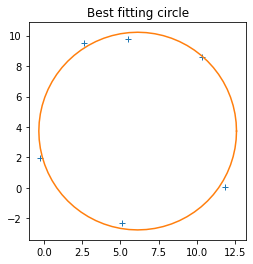

In [26]:

plt.plot(x, y, '+')
plt.plot([x0 + r * cos(alfa / 180 * pi) for alfa in range(0, 361, 5)],
         [y0 + r * sin(alfa / 180 * pi) for alfa in range(0, 361, 5)])
plt.axis('scaled')
_ = plt.title("Best fitting circle")

Let's calculate the estimated accuracy of the unknowns. The weight coefficient matrix of unknowns  is the inverse of normal matrix:
$Q = {N}^{-1}=(A^TA)^{-1}$

The mean error of unit weight (called as proportionality factor, too):

$c^2 = \frac {\sum{v^2}} {(n-3)}$

The variance and covariance matrix:

$C=c^2Q$

The standard deviation of unkowns ${a_1, a_2, a_3}$ are in the diagonal of the variance and covariance matrix. 

Applying the error propagation law, we can get the standard deviation of ${x_0}$, ${y_0}$ and ${r}$. The matrix containg the partial derivatives of the functions to compute ${x_0}$, ${y_0}$ and ${r}$ from ${a_1}$, ${a_2}$ and ${a_3}$:

$F^T=\begin{bmatrix} -0.5 & 0 & 0 \\ 0 & -0.5 & 0 \\ \frac {1} {2r}a_1 & \frac {1} {2r}a_2 & -\frac {1} {r} \end{bmatrix}=\begin{bmatrix} -0.5 & 0 & 0 \\ 0 & -0.5 & 0 \\ -\frac {x_0} {r} & -\frac {y_0} {r} & -\frac {1} {r} \end{bmatrix}$

The variance and covariance matrix of ${x_0}$, ${y_0}$ and ${r}$:

$C_Y=F^TCF$

The variances of ${x_0}$, ${y_0}$ and ${r}$ are in the diagonals of $C_Y$.

In [27]:
c2 = np.sum(res**2) / (np.size(x)-3)
C = c2 * Q
F = np.array([ [-0.5, 0, 0], [0, -0.5, 0], [1/2/r*par[0], 1/2/r*par[1], -1/r] ]).T
C_Y = np.matmul(np.matmul(F.T, C), F)
print(f"c2: {c2:.3f}")
print(f"stdev_x0: {sqrt(C_Y[0][0]):.3f} stdev_y0: {sqrt(C_Y[1][1]):.3f} stdev_r: {sqrt(C_Y[2][2]):.3f}")

c2: 0.176
stdev_x0: 0.020 stdev_y0: 0.018 stdev_r: 0.027


# Robust estimation of circle parameters using RANSAC

What happens if we have one or more outliers among the points? If we have few points we can find outlier from a figure or we can use data snooping. Using laser scanners or photogrammetry we get point clouds where there are huge number of points and usually many outliers/noise.

This case Random Sample Consensus (RANSAC) comes into consideration.

Let's create first a function to get the best fitting (LSM) circle through 3 or more points.

In [28]:
def circle(x, y):
    """ circle through points
        returns tuple of x0, y0, r
    """
    # coefficients of unknowns
    a = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
    # pure term
    b = -(x * x + y * y)
    # solution for a1, a2, a3
    par = np.linalg.lstsq(a, b, rcond=None)
    x0 = -0.5 * par[0][0]
    y0 = -0.5 * par[0][1]
    r = sqrt(x0**2 + y0**2 - par[0][2])
    return x0, y0, r

Test the function using point from the first section.

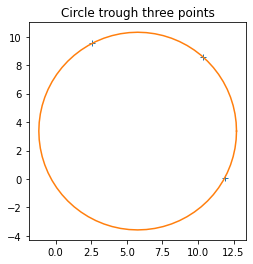

In [29]:
# circle throug three points
x0, y0, r = circle(x[0:3], y[0:3])
plt.plot(x[:3], y[:3], '+')
plt.plot([x0 + r * cos(alfa / 180 * pi) for alfa in range(0, 361, 5)],
         [y0 + r * sin(alfa / 180 * pi) for alfa in range(0, 361, 5)])
plt.axis('scaled')
_ = plt.title("Circle trough three points")

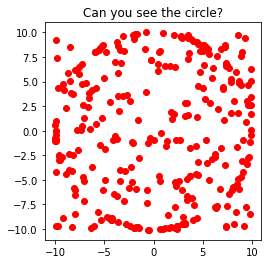

In [30]:
# generating test data
from random import random, seed, randint
seed()
# random points on circle
n = 100    # number of points on the circle
m = 200    # number of outlier points 
r_range = 0.2
r_base = 10.0
x = np.zeros(n+m)
y = np.zeros(n+m)
# points close to circle
for i in range(n):
    alpha = random() * pi * 2   # angle between 0-360 degree in radians
    r = r_base + (random() - 0.5) * r_range   # random radius
    x[i] = r * sin(alpha)
    y[i] = r * cos(alpha)
# outlier (random) points
for i in range(n, n+m):
    x[i] = random() * 2 * r_base -r_base
    y[i] = random() * 2 * r_base -r_base
plt.plot(x, y, 'ro')
plt.title("Can you see the circle?")
_ = plt.axis('scaled')

Fit circle to randomly selected three points several times and choose the one which is close to the most points.

In [36]:
# RANSAC
n_try = n // 3
best = 0
print("centerx  centery   radius    fit   iter")
for i in range(n_try):
    index = [randint(0, n+m-1) for i in range(3)]    # three random index
    x3 = x[index]   # three random points
    y3 = y[index]
    xc, yc, r3 = circle(x3, y3)
    # distance from the circle
    dist = np.absolute(np.sqrt((x - xc)**2 + (y - yc)**2) - r3)
    n_fit = dist[dist < r_range/2].size
    #print(index, i, n_fit)
    if n_fit > best:
        best = n_fit
        best_xc = xc
        best_yc = yc
        best_r = r3
        print(f"{best_xc:7.3f}  {best_yc:7.3f}  {best_r:7.3f}  {best:5d}  {i:5d}")

centerx  centery   radius    fit   iter
 -1.093   -2.891    7.291     10      0
 -0.311    2.215    7.902     13     13
  0.000    2.517    7.916     15     15
 -0.463   -0.572    9.585     25     17
 -0.041   -0.039    9.967     90     30


90


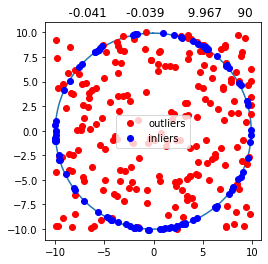

In [37]:
# plot result
plt.title(f"{best_xc:10.3f} {best_yc:10.3f} {best_r:10.3f} {best:5d}")
plt.plot([best_xc + best_r * sin(alfa / 180 * pi) for alfa in range(0, 361)],
         [best_yc + best_r * cos(alfa / 180 * pi) for alfa in range(0, 361)])
dist = np.absolute(np.sqrt((x - best_xc)**2 + (y - best_yc)**2) - best_r)
print(x[dist < r_range/2].size)
plt.plot(x[dist > r_range/2], y[dist > r_range/2], "ro", label='outliers')
plt.plot(x[dist < r_range/2], y[dist < r_range/2], "bo", label="inliers")
plt.axis('scaled')
_ = plt.legend()

Finaly, let's fit LSM circle to the inliers.

In [33]:
xc_final, yc_final, r_final = circle(x[dist < r_range/2], y[dist < r_range/2])
print(f"x0: {xc_final:6.3f}, y0: {yc_final:6.3f}, r: {r_final:6.3f}")

x0: -0.039, y0:  1.257, r:  8.978
